**UNR - TUIA**

# Trabajo Prático N°: 2 - Aprendizaje Automático

### Integrantes:
*   Crenna, Giuliano. Legajo: C-7438/1.
*   Pace, Bruno. Legajo: P-5295/7.
*   Sancho Almenar, Mariano. Legajo: S-5778/9.

In [ ]:
#Tratamiento de datos:
import numpy as np
import pandas as pd
import math

#Gráficos:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Preprocesado y modelado:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, make_scorer, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import random

from typing import Dict, List, Tuple, Any
import os

#Configuración de warnings:
import warnings
warnings.filterwarnings('ignore')

# Ignore UserWarning related to 'penalty=None' and ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, message="Setting penalty=None will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", category=ConvergenceWarning)


ModuleNotFoundError: No module named 'autosklearn'

In [2]:
DATASET_PATH: str = os.path.join(os.getcwd(), 'data', 'weatherAUS.csv')

In [3]:
df: pd.DataFrame = pd.read_csv(DATASET_PATH)

# EDA

Se elige una semilla para que sean siempre las mismas 10 ciudades.

In [4]:
random.seed(42)
choosen_cities: List[str] = random.sample(df['Location'].unique().tolist(), k=10)

In [5]:
df: pd.DataFrame = df[df['Location'].isin(choosen_cities)].reset_index(drop = True) 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30818 entries, 0 to 30817
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           30818 non-null  object 
 1   Location       30818 non-null  object 
 2   MinTemp        30254 non-null  float64
 3   MaxTemp        30421 non-null  float64
 4   Rainfall       30243 non-null  float64
 5   Evaporation    10686 non-null  float64
 6   Sunshine       10127 non-null  float64
 7   WindGustDir    26779 non-null  object 
 8   WindGustSpeed  26797 non-null  float64
 9   WindDir9am     27071 non-null  object 
 10  WindDir3pm     28746 non-null  object 
 11  WindSpeed9am   29921 non-null  float64
 12  WindSpeed3pm   29269 non-null  float64
 13  Humidity9am    29837 non-null  float64
 14  Humidity3pm    29348 non-null  float64
 15  Pressure9am    21206 non-null  float64
 16  Pressure3pm    21250 non-null  float64
 17  Cloud9am       15523 non-null  float64
 18  Cloud3

### Descripción de Variables

1. *Date*: Fecha de la medición.
2. *Location*: Lugar donde se tomaron las mediciones.
3. *MinTemp*: Temperatura mínima del día.
4. *MaxTemp*: Temperatura máxima del día.
5. *Rainfall*: Cantidad de lluvia registrada (en mm).
6. *Evaporation*: Cantidad de agua evaporada (en mm).
7. *Sunshine*: Horas de luz solar en el día.
8. *WindGustDir*: Dirección del viento más fuerte del día.
9. *WindGustSpeed*: Velocidad del viento más fuerte (en km/h).
10. *WindDir9am*: Dirección del viento a las 9 AM.
11. *WindDir3pm*: Dirección del viento a las 3 PM.
12. *WindSpeed9am*: Velocidad del viento a las 9 AM (en km/h).
13. *WindSpeed3pm*: Velocidad del viento a las 3 PM (en km/h).
14. *Humidity9am*: Humedad relativa a las 9 AM.
15. *Humidity3pm*: Humedad relativa a las 3 PM.
16. *Pressure9am*: Presión atmosférica a las 9 AM.
17. *Pressure3pm*: Presión atmosférica a las 3 PM.
18. *Cloud9am*: Cobertura nubosa a las 9 AM.
19. *Cloud3pm*: Cobertura nubosa a las 3 PM.
20. *Temp9am*: Temperatura a las 9 AM.
21. *Temp3pm*: Temperatura a las 3 PM.
22. *RainToday*: Indica si llovió el día de la medición (Sí/No).
23. *RainTomorrow*: Indica si lloverá el día siguiente (Sí/No).

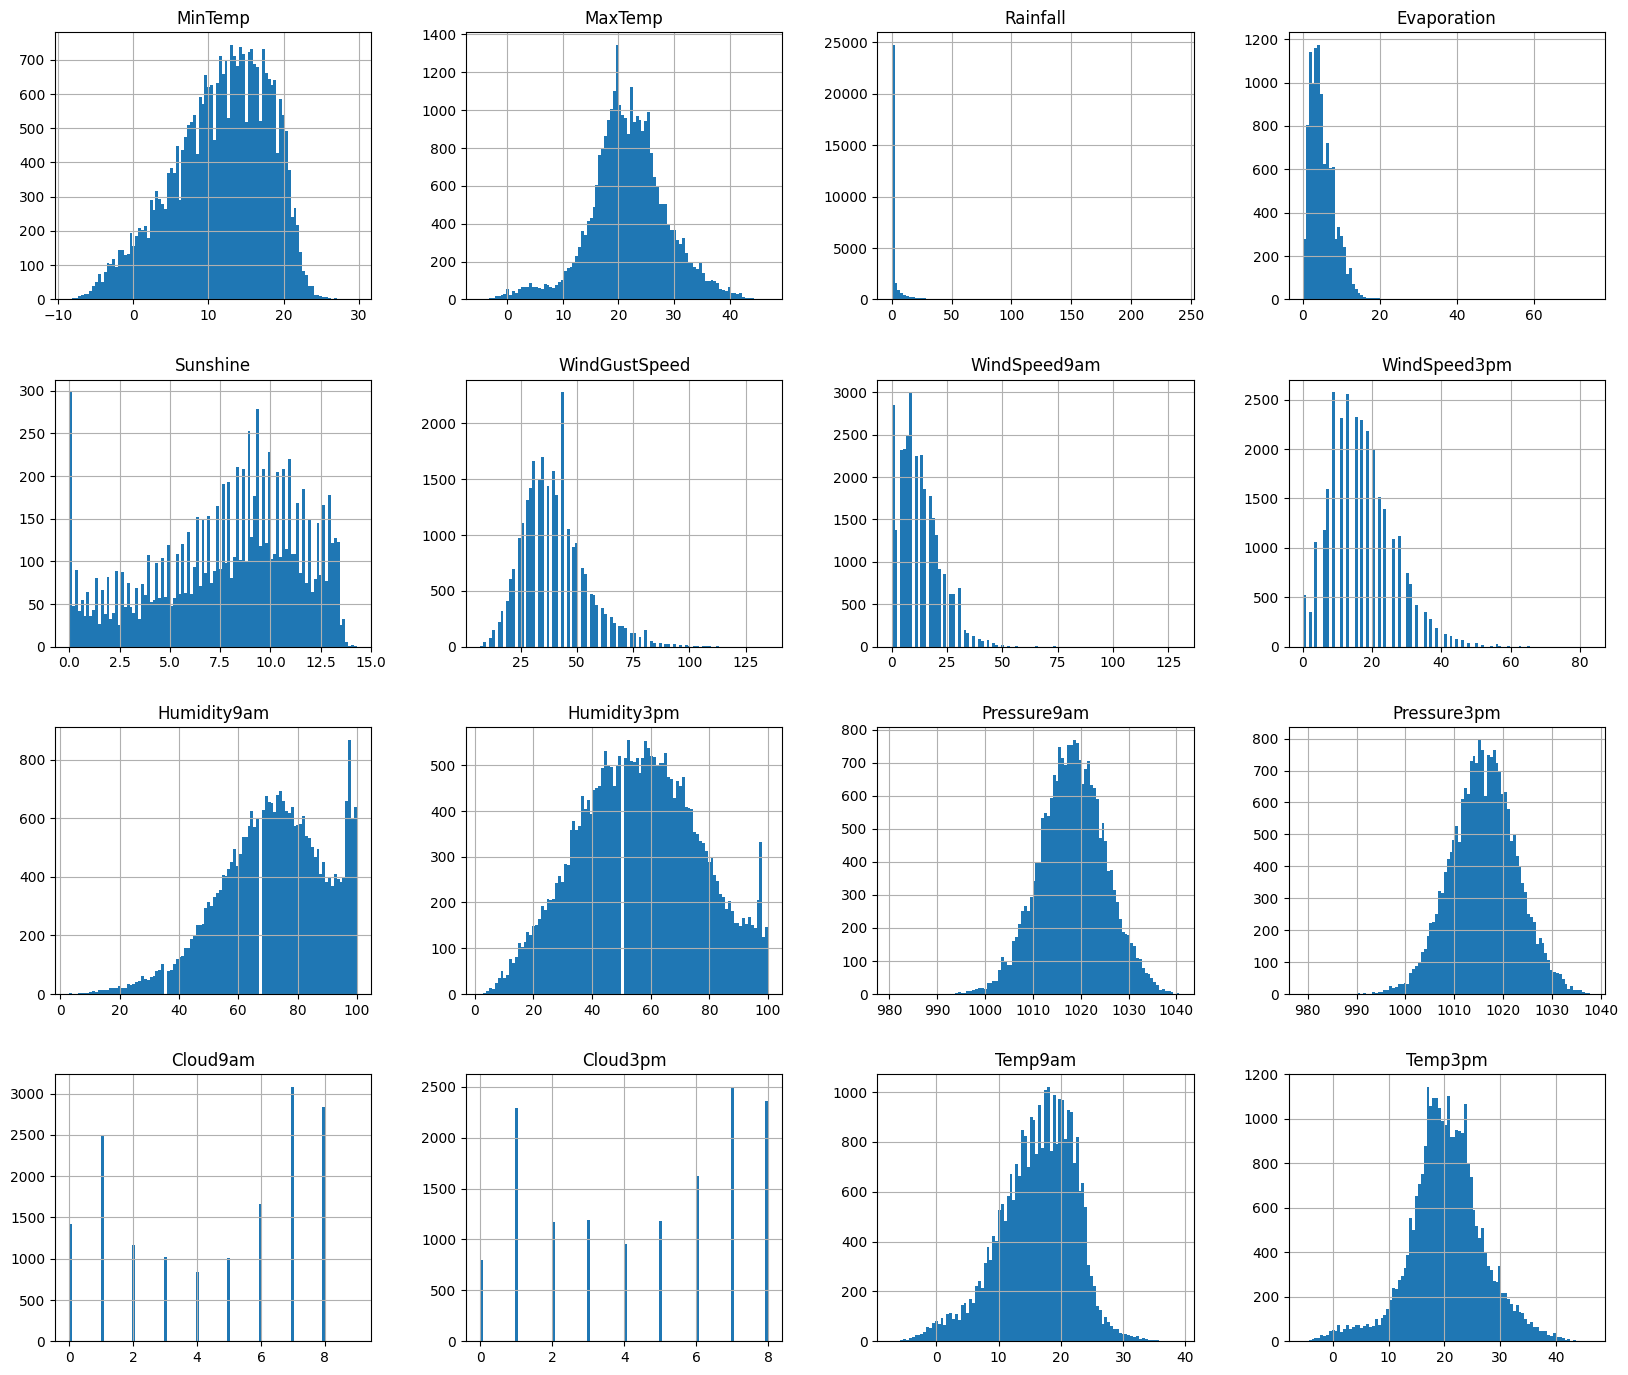

In [7]:
df.hist(figsize= (20,17), bins=100);

La mayoria de las variables presentan distribuciones normales, exceptuando: 

- *Rainfall*, *Evaporation*, *WindSpeed3pm*, *Windspeed9am*, *WindGustSpeed* presentan una distribucion asimetrica a la derecha

**Preprocesado:**
1. Convertimos la variable Date a tipo datetime.

In [8]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

### Series temporales
Es importante observar cómo las temperaturas y precipitaciones varían con el tiempo.

Como podemos observar las series de tiempo de las temperaturas mínimas y máximas son estrictamente estacionales. Mientras que las precipitaciones no presentan estacionalidad.

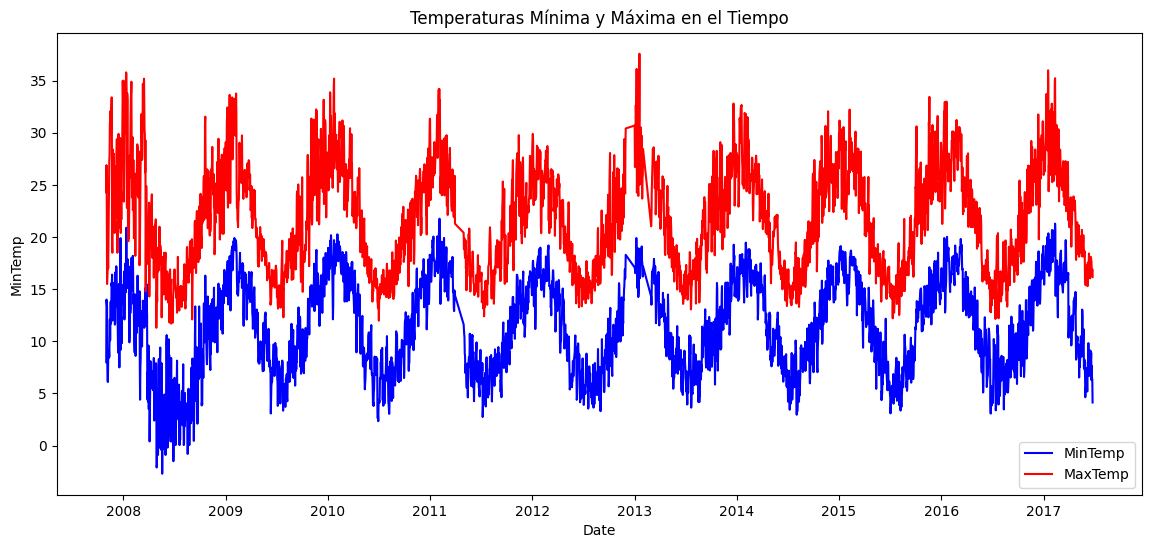

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='MinTemp', data=df, label='MinTemp', color='blue', ci=None)
sns.lineplot(x='Date', y='MaxTemp', data=df, label='MaxTemp', color='red', ci=None)
plt.title("Temperaturas Mínima y Máxima en el Tiempo")
plt.show()

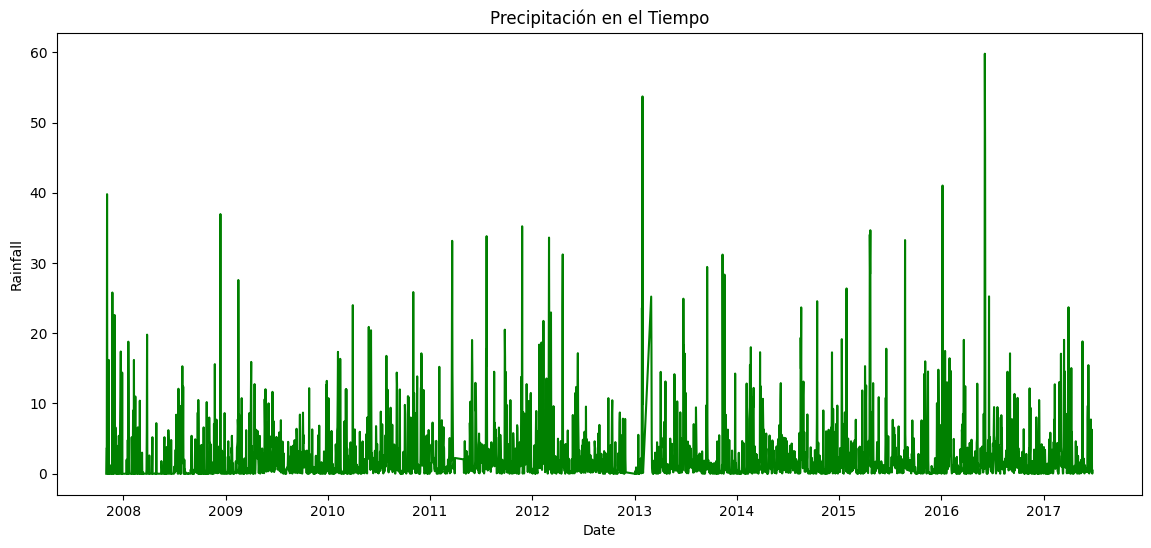

In [10]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Rainfall', data=df, color='green', ci=None)
plt.title("Precipitación en el Tiempo")
plt.show()


### Date

Dado que 'Date' se encuentra con formato 'YYYY-MM-DD', se dividirá en 2 columnas distintas.

- **Year**: Será una variable categórica indicando el año, luego se codificará utilizando One-Hot Encoder.
- **Season**:  Indicará en qué temporada del año ocurrió la medición.

In [11]:
df['Year'] = df['Date'].dt.year

df['Day'] = df['Date'].dt.dayofyear

In [12]:
df[['Date', 'Year', 'Day']].sample(2)

,Date,Year,Day
20569,2014-09-23,2014,266
13884,2014-02-26,2014,57


In [13]:
df.drop(columns= 'Date', inplace=True)


### Mediciones del viento

Las columnas *WindGustDir*, *WindDir9am*, *WindDir3pm*, *WindSpeed3pm* indican la dirección del viento utilizando las direcciones cardinales.

Se transformarán dichas direcciones en las proyecciones que tienen sobre los ejes x e y.

In [14]:
def angle_to_xy(angle: float) -> Tuple[np.float64, np.float64]:
    """
    Función que recibe la dirección del viento en grados y la transformará en projecciones sobre el eje x e y, 
    obteniendo así dos valores numéricos por cada columna.
    """

    if math.isnan(angle):
        return (np.nan, np.nan)

    # Convertimos el ángulo a radianes
    angle_rad = math.radians(angle)


    x = math.sin(angle_rad)
    y = math.cos(angle_rad)

    return (x, y)

In [15]:
direction_angles: dict[str, float] = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
}

columnas_viento: List[str] = ['WindDir3pm','WindDir9am', 'WindGustDir']

for columna in columnas_viento:
    df[columna] = df[columna].map(direction_angles)

# Creamos las columnas con las projecciones x e y para los distintos vientos.
df[['WindDir3pm_x', 'WindDir3pm_y']] = df['WindDir3pm'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindDir9am_x', 'WindDir9am_y']] = df['WindDir9am'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindGustDir_x', 'WindGustDir_y']] = df['WindGustDir'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

In [16]:
df.drop(columns=columnas_viento , inplace=True)


### Columnas categóricas Yes/No

Se remplazan por valores 1 y 0 

In [17]:
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

### Location

Para la localidad, se remplaza su valor con su respectiva coordenada


In [18]:
chosen_cities_coordinates: Dict [str, Dict[str, float]] = {
    "Newcastle": {"latitude": -32.9282, "longitude": 151.7817},
    "BadgerysCreek": {"latitude": -33.8836, "longitude": 150.7386},
    "Penrith": {"latitude": -33.7532, "longitude": 150.6880},
    "Perth": {"latitude": -31.9505, "longitude": 115.8605},
    "Canberra": {"latitude": -35.2809, "longitude": 149.1300},
    "Wollongong": {"latitude": -34.4278, "longitude": 150.8931},
    "Nuriootpa": {"latitude": -34.4658, "longitude": 138.9784},
    "NorahHead": {"latitude": -33.2886, "longitude": 151.6154},
    "NorfolkIsland": {"latitude": -29.0408, "longitude": 167.9547},
    "MountGinini": {"latitude": -35.4622, "longitude": 148.9525}
}


In [19]:
coords_df: pd.DataFrame = pd.DataFrame.from_dict(chosen_cities_coordinates, orient='index') 
coords_df.reset_index(inplace=True) 
coords_df.rename(columns={'index':'Location'}, inplace=True) 
coords_df

,Location,latitude,longitude
0,Newcastle,-32.9282,151.7817
1,BadgerysCreek,-33.8836,150.7386
2,Penrith,-33.7532,150.6880
3,Perth,-31.9505,115.8605
4,Canberra,-35.2809,149.1300
5,Wollongong,-34.4278,150.8931
6,Nuriootpa,-34.4658,138.9784
7,NorahHead,-33.2886,151.6154
8,NorfolkIsland,-29.0408,167.9547
9,MountGinini,-35.4622,148.9525


In [20]:
df: pd.DataFrame = df.merge(coords_df, on='Location', how='left')
df: pd.DataFrame = df.drop(columns=['Location'])

In [21]:
df[['Year', 'Day', 'latitude', 'longitude', 'WindDir3pm_x', 'WindDir3pm_y', 'WindDir9am_x', 'WindDir9am_y','WindGustDir_x', 'WindGustDir_y' ,  'RainToday', 'RainTomorrow']].sample(3)

,Year,Day,latitude,longitude,WindDir3pm_x,WindDir3pm_y,WindDir9am_x,WindDir9am_y,WindGustDir_x,WindGustDir_y,RainToday,RainTomorrow
8527,2016,18,-33.2886,151.6154,0.923880,-0.382683,-0.707107,-0.707107,0.382683,9.238795e-01,1.0,0.0
13343,2012,188,-33.7532,150.6880,-0.382683,-0.923880,-0.382683,-0.923880,-0.707107,-7.071068e-01,1.0,0.0
28364,2010,191,-31.9505,115.8605,-0.923880,0.382683,0.707107,-0.707107,-1.000000,-1.836970e-16,1.0,1.0



## Division del conjunto

Separación test y train conforme a las convenciones del 80% para Train y 20% para test. Se guarda un dataset de validación del 10% del sobrante.

In [22]:
X: pd.DataFrame = df.drop(columns='RainTomorrow')
y: pd.DataFrame = df[['RainTomorrow']] #Variable a predecir

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42
)

## Tratamiento de outliers

Se calculan las variables que tienen valores por encima del quantil 0.99 y por debajo de 0.01. Si tienen, se imputa por la mediana.

In [24]:
def reimpute_outliers(df: pd.DataFrame):
    for column in df.columns:
        if column == 'RainToday':
            continue

        lower_bound: float = df[column].quantile(0.01)
        upper_bound: float = df[column].quantile(0.99)
        median_value: float = df[column].median()
        
        df[column] = df[column].where((df[column] > lower_bound) & (df[column] < upper_bound), median_value)
    
    return df

X_train = reimpute_outliers(X_train)


## Codificación de Year
Usaremos one-hot encoding para el manejo de la columna *Year*.

In [25]:
encoder: OneHotEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')

In [26]:
X_train['Year'].value_counts()

Year
2013    4227
2014    2677
2009    2634
2016    2633
2015    2632
2010    2584
2012    2405
2011    2396
Name: count, dtype: int64

In [27]:
X_train_enc = encoder.fit_transform(X_train[['Year']])
X_test_enc = encoder.transform(X_test[['Year']])

In [28]:
X_train = pd.concat([X_train, X_train_enc], axis=1)
X_test = pd.concat([X_test, X_test_enc], axis=1)

In [29]:
X_train.drop(columns='Year', inplace=True)
X_test.drop(columns='Year', inplace=True)

## Eliminiación de valores faltantes y_train

In [30]:
y_train.isna().sum()

RainTomorrow    408
dtype: int64

y_train presenta 22188 datos, de los cuales 408 son datos faltantes. 

Esto representa aproximadamente 1.8% del dataset. Por eso se decide dropearlos.

In [31]:
X_train.reset_index(inplace=True)
y_train.reset_index(inplace=True)

# Se almacenan los indices cuyos valores no son Nan
indices_validos: pd.Index = y_train.dropna().index

Se filtran los mismos indices válidos en ambos conjuntos de train

In [32]:
X_train: pd.DataFrame = X_train.iloc[indices_validos]
y_train: pd.Series = y_train.iloc[indices_validos]

In [33]:
y_train.isna().sum()

index           0
RainTomorrow    0
dtype: int64

In [34]:
#Eliminación de columnas indices
X_train = X_train.drop(columns=['index'])
y_train = y_train.drop(columns=['index'])

## Eliminación de faltantes de y_test

Se dropean los valores nulos de y_test y X_test con los mismo indices. Ya que representan un 2% del total. Se tomó esta decisión porque, de tener valores nulos, genera conflicto con la matriz de confusión.

Lo que pretende hacer la matriz de confusión es intentar determinar en qué lugar están los valores nan y como no puede, falla.

In [35]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6164 entries, 19140 to 25213
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RainTomorrow  6040 non-null   float64
dtypes: float64(1)
memory usage: 96.3 KB


In [36]:
X_test.reset_index(inplace=True)
y_test.reset_index(inplace=True)

# Se almacenan los indices cuyos valores no son Nan
indices_validos: pd.Index = y_test.dropna().index

In [37]:
X_test: pd.DataFrame = X_test.iloc[indices_validos]
y_test: pd.Series = y_test.iloc[indices_validos]

In [38]:
# Eliminación de columnas indices
X_test = X_test.drop(columns=['index'])
y_test = y_test.drop(columns=['index'])

## Análisis de valores duplicados en X_train

Análisis duplicados en X_train. No se realiza con y_train ya que son 0 y 1 y daría duplicados.

In [39]:
X_train.duplicated().sum()

np.int64(0)

No se encuentran valores duplicados.

## Imputación de valores faltantes en X_train y X_test

Se realiza la imputación por medio de KNN.

In [40]:
knn = KNNImputer(n_neighbors=5)

X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)

## Balanceo de Y_train

In [41]:
y_train.value_counts()

RainTomorrow
0.0             16697
1.0              5083
Name: count, dtype: int64

Se presenta un desbalance en el dataframe y_train, predominando ampliamente los días que no llueven.

In [42]:
print(f'Los días de lluvia del dataset y_train representan el {round(5083*100/y_train.shape[0],2)}%')

Los días de lluvia del dataset y_train representan el 23.34%


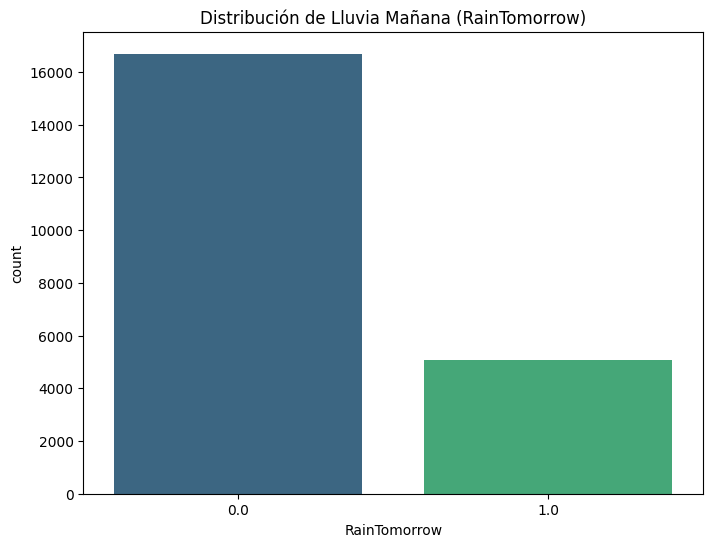

In [43]:
plt.figure(figsize=(8, 6))
sns.countplot(x='RainTomorrow', data=y_train, palette='viridis')
plt.title("Distribución de Lluvia Mañana (RainTomorrow)")
plt.show()



## Estandarizado

Se estanadariza usando Z-Score

In [44]:
scaler: StandardScaler = StandardScaler()

In [45]:
X_train: pd.DataFrame = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test: pd.DataFrame = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)


## Matriz de correlación

Se quitan los años porque son dummies.

In [46]:
columns_sin_anios: list[str] = []

columns: list[str] = X_train.columns.tolist()

for col in columns:
    if 'Year' not in col:
        columns_sin_anios.append(col)

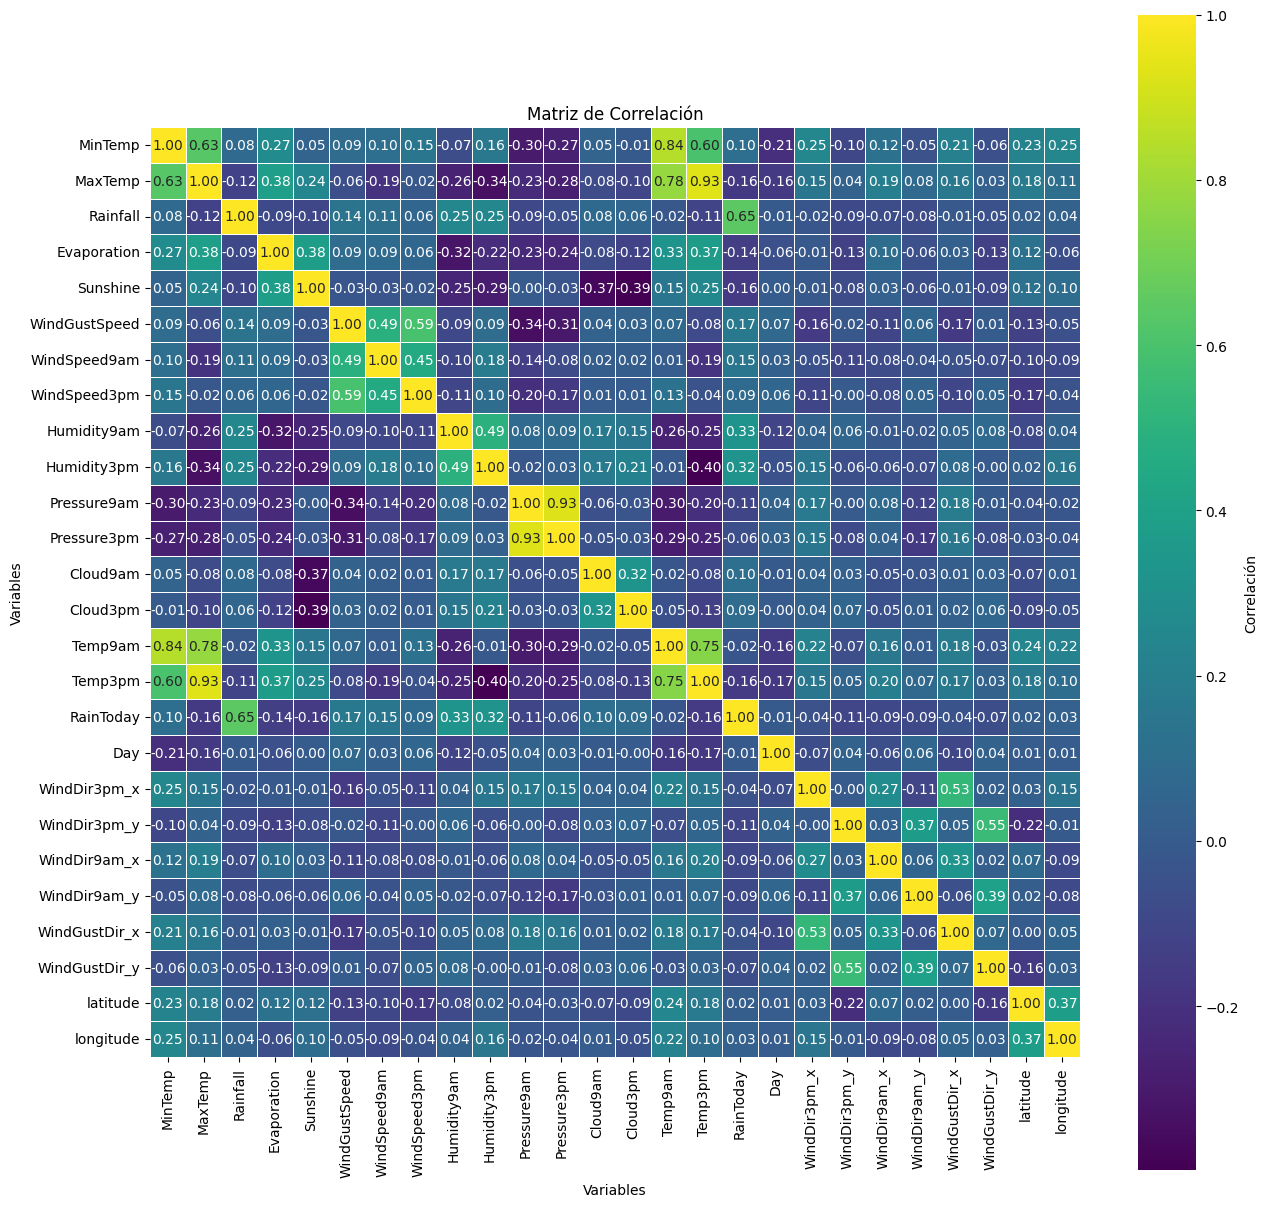

In [47]:
corr_matrix: np.ndarray = X_train[columns_sin_anios].corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, 
            annot=True,  
            cmap='viridis',  
            cbar_kws={'label': 'Correlación'}, 
            square=True,  
            fmt='.2f', 
            linewidths=0.5,  
            linecolor='white')  

plt.title('Matriz de Correlación')
plt.xlabel('Variables')
plt.ylabel('Variables')

plt.show()

Se encuentras correlaciones fuertes, destacando: 

- Pressure9am - Pressure3pm
- MinTemp - Temp9am
- MaxTemp - Temp3pm
- MaxTemp - Temp9am
- Temp9am - Temp3pm

Estas correlaciones tienen sentido y reflejan patrones meteorológicos típicos de comportamiento de las variables relacionadas con la temperatura y la presión.


# Implementación de modelos

Dado que el dataset se encuentra altamente desbalanceado, se descarta el uso de Accuracy como metrica.

Por lo que analizará el modelo en base a Precision, recall, F1

En una primera instancia, se analiza el modelo de regresión logistica 


### Regresión logística sin balance

In [48]:
# Realizamos esto ya que en el conjunto y_test se codifica en 1 y 0 pero en formato np.float32 y debe ser entero.
y_test = y_test.astype(int)

In [49]:
y_test.isna().count()

RainTomorrow    6040
dtype: int64

In [50]:
# definimos funciona para mostrar los resultados
def mostrar_resultados(y_test: np.ndarray, pred_y: np.ndarray, title_: str) -> None:
      conf_matrix: np.ndarray = confusion_matrix(y_test, pred_y)
  
      fig = px.imshow(conf_matrix, 
          text_auto=True, 
          title=title_, 
          labels={'x':'Predicción', 'y':'Actual'}, 
          x=['No llueve', 'Llueve'], 
          y=['No llueve', 'Llueve'])
  
      fig.show()
    

In [51]:
logr_model = LogisticRegression(C=1.0, penalty='l2', random_state=1, solver="newton-cg")
logr_model.fit(X_train, y_train)
  
pred_y: np.ndarray = logr_model.predict(X_test)

In [52]:
mostrar_resultados(y_test,pred_y, 'Matriz de Confusión sin balanceo')


La precisión general del modelo es bastante alta, pero hay un número significativo de falsos negativos, lo que indica que el modelo podría estar fallando en identificar algunas instancias positivas.
La alta especificidad sugiere que el modelo es efectivo para identificar negativos, mientras que la sensibilidad sugiere que se podría mejorar la identificación de positivos.

In [53]:
print (classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4648
           1       0.65      0.54      0.59      1392

    accuracy                           0.83      6040
   macro avg       0.76      0.73      0.74      6040
weighted avg       0.82      0.83      0.82      6040



In [54]:
y_scores = logr_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

In [55]:
auc(fpr, tpr)

np.float64(0.8351373474192337)

In [56]:
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

In [57]:
mostrar_resultados(y_test,y_pred_optimal, 'Matriz de Confusión sin balanceo, calculando umbral óptimo')

Si bien con el umbral mejoramos los falsos positivos, la diferencia no es significativa.

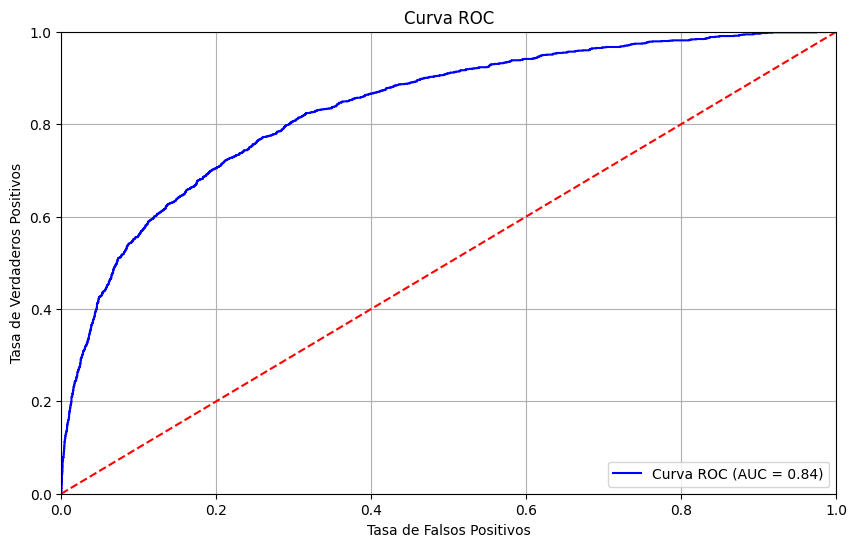

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

La curva ROC con un AUC de 0.84, indica que el modelo es capaz de distinguir correctamente los días en los que **NO llueve** de aquellos en los que sí, con un balance adecuado entre la detección correcta de lluvia y la minimización de falsas alarmas. Aunque no es perfecto, el modelo es bastante preciso en sus predicciones.

Sabiendo también las métricas de recall, f1-score, support sabemos que el modelo tiene un buen desempeño prediciendo cuándo no llueve pero malo con respecto a cuando sí llueve.

In [59]:
logr_model_balanced = LogisticRegression(C=1.0, penalty='l2',class_weight='balanced', random_state=1, solver="newton-cg")
logr_model_balanced.fit(X_train, y_train)
  
pred_y_balanced: np.ndarray = logr_model_balanced.predict(X_test)

In [60]:
print (classification_report(y_test, pred_y_balanced))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      4648
           1       0.46      0.79      0.58      1392

    accuracy                           0.73      6040
   macro avg       0.69      0.75      0.69      6040
weighted avg       0.81      0.73      0.75      6040



In [61]:
auc(fpr, tpr)

np.float64(0.8351373474192337)

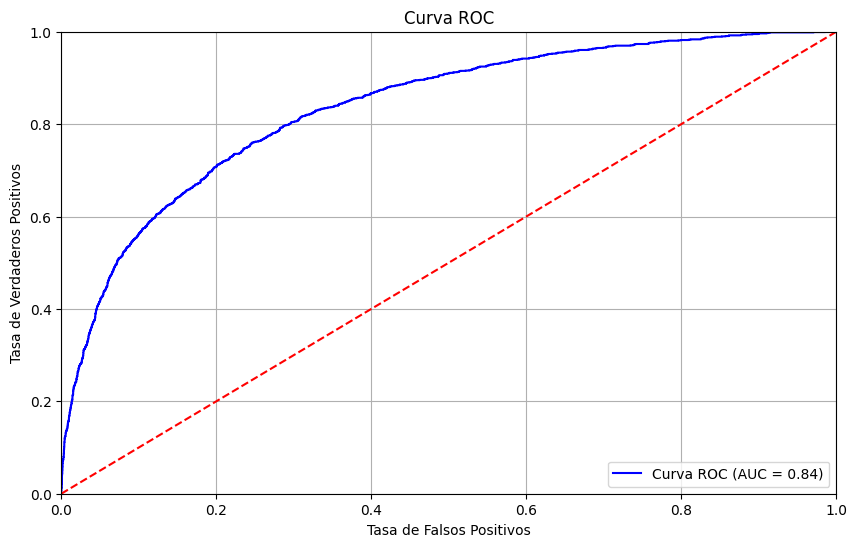

In [62]:
y_scores = logr_model_balanced.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Se hizo una prueba de cambiar los parámetros de la funcion de LogisticRegresion. Si bien la curva es apenas distinta, el AUC es idéntico.

In [63]:
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

In [64]:
mostrar_resultados(y_test,y_pred_optimal, 'Matriz de Confusión sin balanceo, calculando umbral óptimo V2')

La matriz de confusion es exactamente la misma.

## Analisis de 'buen' o 'mal' fitting

El AUC refleja un buen desempeño general del modelo, indicando que predice correctamente en la mayoría de los casos. Sin embargo, hemos identificado que el modelo funciona mejor prediciendo los días en los que no llueve, mientras que muestra deficiencias al predecir los días en los que sí llueve. Este problema probablemente se deba a un desbalance en el conjunto de datos, donde los días sin lluvia podrían estar representados en mayor cantidad que los días con lluvia, lo que lleva al modelo a favorecer la clase mayoritaria.

## Validacion Cruzada
1. Se observa una disminución rápida en la precisión entre los primeros dos folds, lo que es inusual. Esto sugiere que los datos podrían no estar bien equilibrados o que el modelo no es consistente. 
2. Las curvas de KFold y StratifiedKFold son casi idénticas, lo que indica que la estratificación no afecta significativamente la precisión en este conjunto de datos.
3. La precisión que cae a cero en el segundo fold sugiere problemas potenciales, como clases desbalanceadas, datos de baja calidad o configuraciones incorrectas en el entrenamiento.

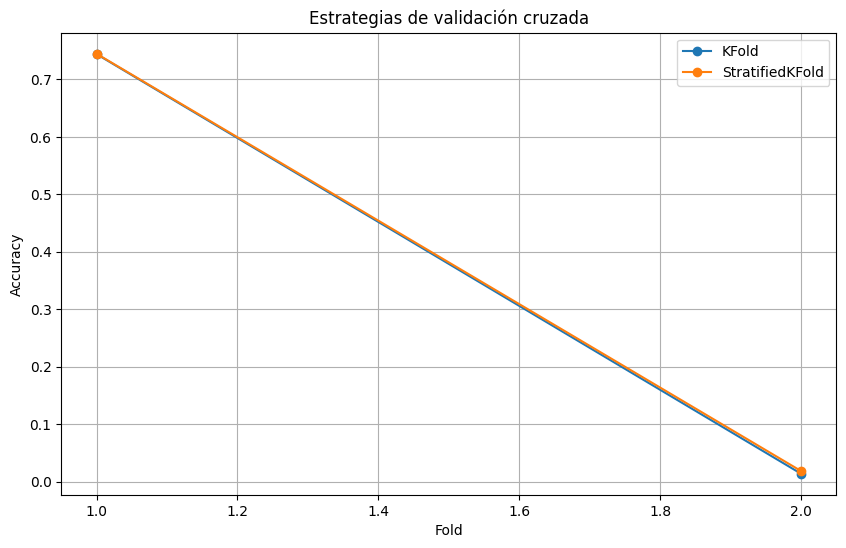

Estrategia: KFold - Media: 0.744, Desvío Estándar: 0.014
Estrategia: StratifiedKFold - Media: 0.745, Desvío Estándar: 0.019


In [65]:
cv_strategies: List[Tuple[str, Any]] = [
    ("KFold", KFold(n_splits=20, shuffle=True, random_state=42)),
    ("StratifiedKFold", StratifiedKFold(n_splits=20, shuffle=True, random_state=42))
]

results: dict = {}

for name, cv in cv_strategies:
    scores = cross_val_score(logr_model_balanced, X_train, y_train, cv=cv)
    results[name] = (scores.mean(), scores.std())

plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

for name, (mean, std) in results.items():
    print(f"Estrategia: {name} - Media: {mean:.3f}, Desvío Estándar: {std:.3f}")

# Modelo base

Para esta ocasión elegimos un modelo de regresión lineal con una única variable. Elegimos la columna de 'RainToday' para entrenar el modelo.

In [66]:
lr_model = LinearRegression()
lr_model.fit(X_train[['RainToday']], y_train)

lr_y_pred = lr_model.predict(X_test[['RainToday']])


# Evaluar el modelo.
linear_mse: np.float64 = mean_squared_error(y_test, lr_y_pred)
linear_r2: np.float64 = r2_score(y_test, lr_y_pred)

print(f'El error cuadrático medio es: {linear_mse}')
print(f'El r2 score es: {linear_r2}')

El error cuadrático medio es: 0.1633220262229508
El r2 score es: 0.07909828478705438


El análisis de las métricas en este caso es trivial. El error cuadrático medio si bien es bajo, el r2 score tiene un desempeño muy poco deseable. Esto se debe a que no

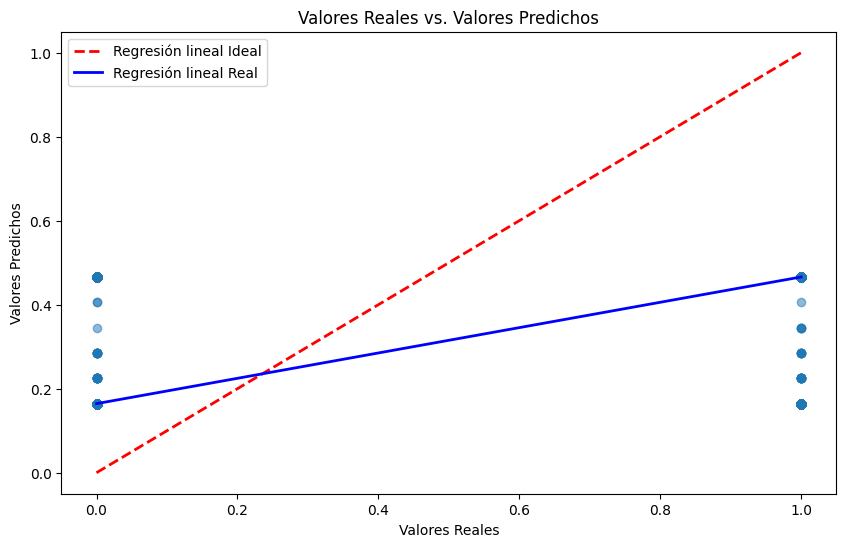

Mean Squared Error: 0.1633220262229508
R^2 Score: 0.07909828478705438


In [67]:
# Grafica de la regresión

plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label = 'Regresión lineal Ideal')
plt.plot([y_test.min(), y_test.max()], [lr_y_pred.min(), lr_y_pred.max()], 'b', lw=2, label = 'Regresión lineal Real')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.legend()
plt.title('Valores Reales vs. Valores Predichos')
plt.show()

print(f'Mean Squared Error: {linear_mse}')
print(f'R^2 Score: {linear_r2}')

Con las métricas del modelo base, podemos compararlo con el modelo de regresión logística. Aunque las métricas no son idénticas, es evidente que el rendimiento del modelo base, que utiliza una regresión logística de una sola variable, es bastante deficiente.

# Optimización de Hiperparámetros

Se arma un diccionario para los parámetros a optimizar. Se utiliza RandomSearchCV para optimizar los parámetros. Este es utilizado debido a que es menos costoso que GridSearchCV.

In [80]:
parametros: dict[str, list[Any]] = {
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'dual':[False, True],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'newton-cg'],
    'max_iter': [50,150,300, 500,1000, 2000,5000]
}

In [107]:
lr_model_randomizedCV = LogisticRegression()

scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'Accuracy': make_scorer(accuracy_score)
}

random_search = RandomizedSearchCV(
    estimator=lr_model_randomizedCV,
    param_distributions=parametros,
    n_iter=50,  
    scoring=scoring,
    refit='F1',  
    cv=5,  
    random_state=42,
    n_jobs=-1  
)

# Perform the search
random_search.fit(X_train, y_train['RainTomorrow'])

pred_y_randomizedCV = random_search.predict(X_test)

# Get the best parameters and scores
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)
print("Best Accuracy Score:", random_search.cv_results_['mean_test_Accuracy'][random_search.best_index_])

/home/bn/Documents/TUIA/ML/.venv_ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/bn/Documents/TUIA/ML/.venv_ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/bn/Documents/TUIA/ML/.venv_ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/bn/Documents/TUIA/ML/.venv_ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/bn/Documents/TUIA/ML/.venv_ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/bn/D

Best Parameters: {'tol': 0.001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 500, 'fit_intercept': True, 'dual': False, 'class_weight': None, 'C': 0.001}
Best F1 Score: 0.7958063208655208
Best Accuracy Score: 0.8117998163452709


In [108]:
print('Rendimiento de regresión logística con Randomized CV: \n')
print (classification_report(y_test, pred_y_randomizedCV))
print('--------------------------------------------------------------------------------')
print('Rendimiento de regresión logística hecha anteriormente: \n')
print (classification_report(y_test, pred_y_balanced))

Rendimiento de regresión logística con Randomized CV: 

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4648
           1       0.62      0.54      0.58      1392

    accuracy                           0.82      6040
   macro avg       0.74      0.72      0.73      6040
weighted avg       0.81      0.82      0.81      6040

--------------------------------------------------------------------------------
Rendimiento de regresión logística hecha anteriormente: 

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      4648
           1       0.46      0.79      0.58      1392

    accuracy                           0.73      6040
   macro avg       0.69      0.75      0.69      6040
weighted avg       0.81      0.73      0.75      6040



El modelo realizado con RandomizedSearchCV tiene un rendimiento superior en la predicción de días de lluvia en comparación con el modelo ajustado manualmente. La precisión en conjunto con el f1-score en la detección de días lluviosos mejora, lo que indica un mejor equilibrio entre precisión y cobertura. Aunque el recall para días de lluvia es ligeramente menor en el modelo optimizado, la precisión general y el rendimiento equilibrado en ambas clases reflejan un modelo más robusto y confiable.

# Auto ML

In [112]:
#import autosklearn.classification
